# Training, Testing, Validation, Generalisation

When we wish to find the right model for a problem, the following pipeline is generally used:

1. We use a *training* data set to automatically generate a model, given a hyperparameter
2. We use a *validation* data set to tune the hyperparameters
3. We use a *testing* data set to measure the performance of the tuned model

This is done to avoid biased choice of models and hyperparameters. Simply put, if we choose and measure everything on the training set, we will have a biased measurement of the quality of our model. For that reason, we follow the principle of optimising on some data, and measuring on another set of data.

The problem of biased evaluation disappears with an unbounded amount of data. However, it is only rarely that we have enough data for this to not matter.

However, the performance of a model is always limited by the model class. If we are using a linear model to characterise a non-linear system, no amount of data will help us find the correct model, since we already made the mistake of limiting ourselves to linear models.

In [16]:
import numpy as np
import scipy

# generate data
n_training_data = 100
n_valid_data = 100
n_test_data = 10000

class GaussianGenerator:
    def __init__(self, n_dim, n_classes, class_prob):
        self.mean = np.zeros([n_classes, n_dim])
        self.covariance = np.zeros([n_classes, n_dim, n_dim])
        for c in range(n_classes):
            self.mean[c] = np.random.normal(n_dim)
            self.covariance[c] = scipy.stats.wishart.rvs(n_dim, np.identity(n_dim))
        self.n_dim = n_dim
        self.n_classes = n_classes
        self.class_prob = class_prob
    def generate(self, n_data):
        X = np.zeros([n_data, n_dim])
        y = np.zeros(n_data)
        for t in range(n_data):
            c = np.random.choice(range(self.n_classes), p = self.class_prob)
            X[t] = scipy.stats.multivariate_normal.rvs(self.mean[c], self.covariance[c])
            y[t] = c
        return X, y

n_dim = 2
n_classes = 2
class_prob = [0.8, 0.2]
generator = GaussianGenerator(n_dim, n_classes, class_prob)

train_X, train_y = generator.generate(n_training_data)
valid_X, valid_y = generator.generate(n_valid_data)
test_X, test_y = generator.generate(n_test_data)


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn.metrics import accuracy_score


# The effect of hyperparameters on accuracy

We are running an experiment where we try and tune the main hyperparameter of the kNN-classifier algorithm. Here we can see that the accuracy is different on the train and test set. This means that we cannot correctly optimise for the value we want. Simply put, and as we saw in the discussion about optimising the approximation of a function, we are optimising one function while targetting another. This is one source of generalisation error.

This is effect is more prominent when we are optimising on the training set.


In [18]:
knn_max = 50
test_score = np.zeros(knn_max)
valid_score = np.zeros(knn_max)
train_score = np.zeros(knn_max)
for n_neighbors in range(1, knn_max + 1):
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    clf.fit(train_X, train_y)
    y = clf.predict(train_X)
    train_score[n_neighbors-1] = accuracy_score(y, train_y)
    y = clf.predict(valid_X)
    valid_score[n_neighbors-1] = accuracy_score(y, valid_y)
    y = clf.predict(test_X)
    test_score[n_neighbors-1] = accuracy_score(y, test_y)



1


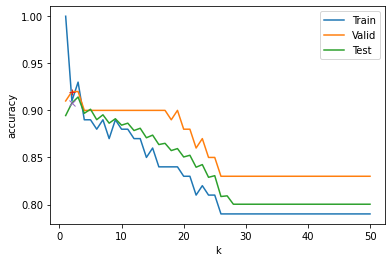

In [19]:
k_valid = np.argmax(valid_score)
plt.plot(range(1,knn_max+1), train_score)
plt.plot(range(1,knn_max+1),valid_score)
plt.plot(range(1,knn_max+1),test_score)
plt.plot(k_valid + 1, valid_score[k_valid], "+")
plt.plot(k_valid + 1, test_score[k_valid], "x")
plt.legend(["Train", "Valid", "Test"])
plt.xlabel("k")
plt.ylabel("accuracy")
print(k_valid + 1)

In [20]:
# The effect of the amount of training data on accuracy
n_neighbors = k_valid + 1
train_max = 100
test_score = np.zeros(train_max)
valid_score = np.zeros(train_max)
train_score = np.zeros(train_max)
for n_data in range(1, train_max + 1):
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(min(n_data,n_neighbors))
    clf.fit(train_X[0:n_data], train_y[0:n_data])
    y = clf.predict(train_X)
    train_score[n_data - 1] = accuracy_score(y, train_y)
    y = clf.predict(valid_X)
    valid_score[n_data-1] = accuracy_score(y, valid_y)
    y = clf.predict(test_X)
    test_score[n_data-1] = accuracy_score(y, test_y)


Text(0, 0.5, 'accuracy')

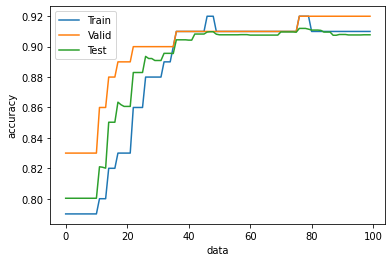

In [21]:
plt.plot( train_score)
plt.plot(valid_score)
plt.plot(test_score)
plt.legend(["Train", "Valid", "Test"])
plt.xlabel("data")
plt.ylabel("accuracy")